In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import joblib

In [2]:
# Suppress unimportant warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:

# Load preprocessed data splits from .pkl files
def load_splits(save_dir):
    """
    Loads the data splits from .pkl files.

    Parameters:
        save_dir (str): Directory containing the .pkl files.

    Returns:
        dict: Dictionary containing the loaded data splits.
    """
    data_splits = {}
    for file_name in os.listdir(save_dir):
        if file_name.endswith(".pkl"):
            key = file_name.split(".pkl")[0]
            file_path = os.path.join(save_dir, file_name)
            with open(file_path, "rb") as f:
                data_splits[key] = pickle.load(f)
    print(f"Data splits loaded from .pkl files in directory: {save_dir}")
    return data_splits

In [4]:
# Set the path for the dataset folder
folder = '../dataset'
os.makedirs(folder, exist_ok=True)
dataset_file = os.path.join(folder, 'creditcard.csv')

In [5]:

# Directory for the preprocessed data
processed_data_dir = "../dataset/splits_pkl"



In [6]:
# Load data splits
data_splits = load_splits(processed_data_dir)

Data splits loaded from .pkl files in directory: ../dataset/splits_pkl


In [7]:
# Access loaded data splits
X = data_splits["X"]
y = data_splits["Y"]
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]


In [8]:
# Convert the dataset into DMatrix (internal format used by XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
# Define XGBoost parameters with class_weight adjustment for imbalance
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',  # Use GPU-accelerated histogram-based method
    'predictor': 'gpu_predictor',  # Use GPU for prediction
    'gpu_id': 0,  # Use the first GPU (if you have multiple)
    'scale_pos_weight': np.sum(y_train == 0) / np.sum(y_train == 1)  # Handling class imbalance
}

In [10]:
# Perform Hyperparameter Tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [11]:
# Initialize the model
xgb_model = xgb.XGBClassifier(tree_method='hist', predictor='gpu_predictor', gpu_id=0)

In [12]:
# Use StratifiedKFold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters from GridSearchCV
print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters from GridSearchCV: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}


In [13]:
# Train the model with the best parameters
best_model = grid_search.best_estimator_

In [14]:
# Make predictions
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [15]:
# Convert predictions to binary values (fraud or not)
y_train_pred = [1 if prob > 0.5 else 0 for prob in y_train_pred_proba]
y_val_pred = [1 if prob > 0.5 else 0 for prob in y_val_pred_proba]
y_test_pred = [1 if prob > 0.5 else 0 for prob in y_test_pred_proba]


In [16]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"\n{model_name} Performance:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()
    # ROC-AUC Score
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f"{model_name} ROC-AUC: {roc_auc:.4f}")
    return roc_auc

Evaluating on Training Set:

XGBoost (Train) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159216
           1       1.00      1.00      1.00    159216

    accuracy                           1.00    318432
   macro avg       1.00      1.00      1.00    318432
weighted avg       1.00      1.00      1.00    318432

Confusion Matrix:
[[159216      0]
 [     0 159216]]


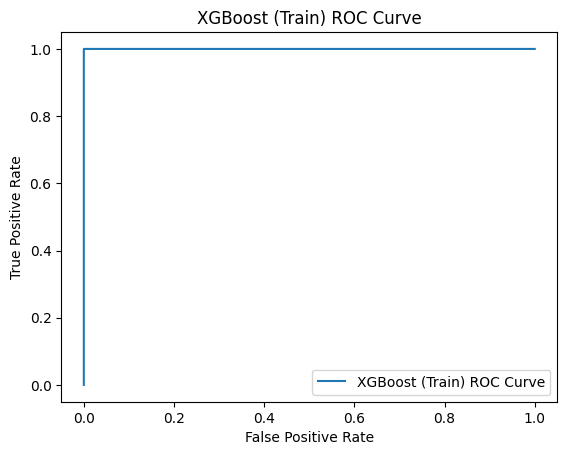

XGBoost (Train) ROC-AUC: 1.0000


In [17]:
# Evaluate XGBoost on Training, Validation, and Test Sets
print("Evaluating on Training Set:")
train_roc_auc = evaluate_model(y_train, y_train_pred, y_train_pred_proba, "XGBoost (Train)")

Evaluating on Validation Set:

XGBoost (Validation) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39804
           1       1.00      1.00      1.00     39805

    accuracy                           1.00     79609
   macro avg       1.00      1.00      1.00     79609
weighted avg       1.00      1.00      1.00     79609

Confusion Matrix:
[[39780    24]
 [    0 39805]]


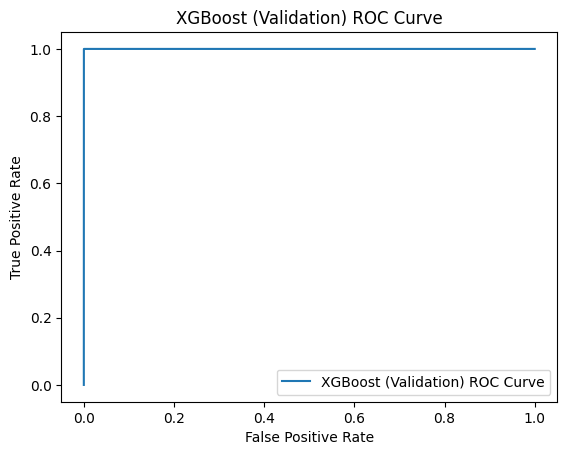

XGBoost (Validation) ROC-AUC: 1.0000


In [18]:
print("Evaluating on Validation Set:")
val_roc_auc = evaluate_model(y_val, y_val_pred, y_val_pred_proba, "XGBoost (Validation)")

Evaluating on Test Set:

XGBoost (Test) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

Confusion Matrix:
[[85247    48]
 [    0 85294]]


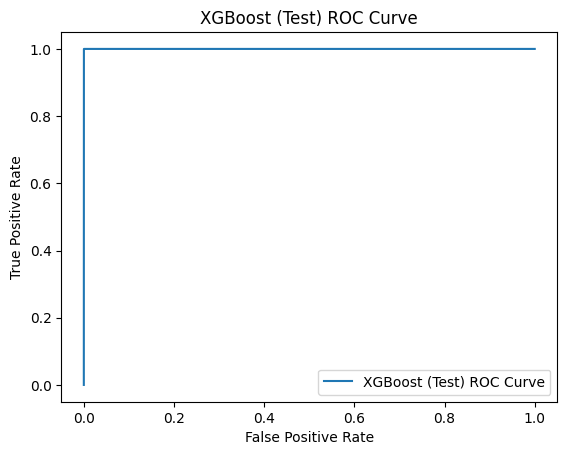

XGBoost (Test) ROC-AUC: 1.0000


In [19]:
print("Evaluating on Test Set:")
test_roc_auc = evaluate_model(y_test, y_test_pred, y_test_pred_proba, "XGBoost (Test)")


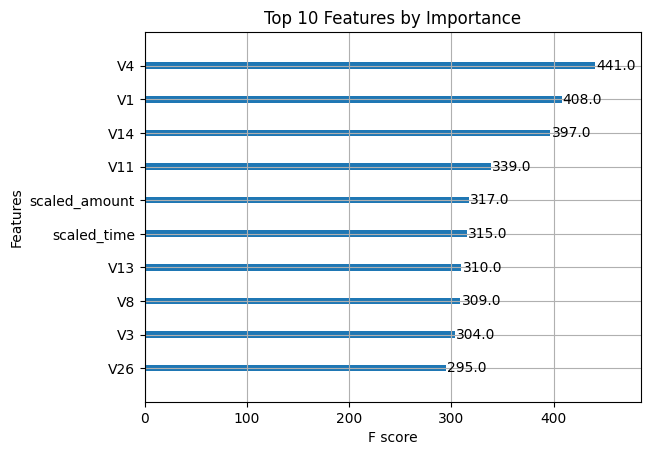

In [20]:
# Plot feature importance
xgb.plot_importance(best_model, max_num_features=10, importance_type='weight', title="Top 10 Features by Importance")
plt.show()


In [21]:
# Check for Overfitting
if abs(train_roc_auc - val_roc_auc) < 0.05 and abs(val_roc_auc - test_roc_auc) < 0.05:
    print("The model is not overfitting. The performance on the training, validation, and test sets is consistent.")
else:
    print("Warning: Potential Overfitting detected! Performance varies significantly across sets.")

The model is not overfitting. The performance on the training, validation, and test sets is consistent.


In [22]:
# Save the Model
joblib.dump(best_model, '../Models/fraud_detection_xgboost_model.pkl')

['../Models/fraud_detection_xgboost_model.pkl']